In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import numpy as np

In [2]:
df_train = pd.read_csv('train_sent_emo.csv', index_col=0)
df_dev = pd.read_csv('dev_sent_emo.csv', index_col=0)

In [3]:
#convert utt to str
df_train['Utterance'] = df_train['Utterance'].astype(str)
df_dev['Utterance'] = df_dev['Utterance'].astype(str)

In [4]:
#Create a new column named 'image_names' in the DataFrame to store the image file names

df_train['image_names'] = df_train.apply(lambda row: f'dia{row["Dialogue_ID"]}_utt{row["Utterance_ID"]}', axis=1)
df_dev['image_names'] = df_dev.apply(lambda row: f'dia{row["Dialogue_ID"]}_utt{row["Utterance_ID"]}', axis=1)


In [5]:
import glob
import os

cwd = os.getcwd()

path_anger = cwd + '/BPI-MELD-main/BPI-MELD-main/train/train_splits_images/anger_oneface/'
path_joy = cwd + '/BPI-MELD-main/BPI-MELD-main/train/train_splits_images/joy_oneface/'
path_neutral = cwd + '/BPI-MELD-main/BPI-MELD-main/train/train_splits_images/neutral_oneface/'
path_anger_dev = cwd + '/BPI-MELD-main/BPI-MELD-main/dev/dev_splits_images/anger_oneface/'
path_joy_dev = cwd + '/BPI-MELD-main/BPI-MELD-main/dev/dev_splits_images/joy_oneface/'
path_neutral_dev = cwd + '/BPI-MELD-main/BPI-MELD-main/dev/dev_splits_images/neutral_oneface/'

files_anger = glob.glob(os.path.join(path_anger, '*.jpg'))
files_joy = glob.glob(os.path.join(path_joy, '*.jpg'))
files_neutral = glob.glob(os.path.join(path_neutral, '*.jpg'))
files_anger_dev = glob.glob(os.path.join(path_anger_dev, '*.jpg'))
files_joy_dev = glob.glob(os.path.join(path_joy_dev, '*.jpg'))
files_neutral_dev = glob.glob(os.path.join(path_neutral_dev, '*.jpg'))

files_anger = set([file.split("\x5c")[-1][:-6] for file in files_anger])
files_joy = set([file.split("\x5c")[-1][:-6] for file in files_joy])
files_neutral = set([file.split("\x5c")[-1][:-6] for file in files_neutral])
files_anger_dev = set([file.split("\x5c")[-1][:-6] for file in files_anger_dev])
files_joy_dev = set([file.split("\x5c")[-1][:-6] for file in files_joy_dev])
files_neutral_dev = set([file.split("\x5c")[-1][:-6] for file in files_neutral_dev])

all_files = files_anger.union(files_joy).union(files_neutral)
all_files_dev = files_anger_dev.union(files_joy_dev).union(files_neutral_dev)

print(len(all_files))
print(len(all_files_dev))

# all_files_train_dev = all_files.union(all_files_dev)

3375
359


In [6]:
df_train = df_train[df_train['image_names'].isin(list(all_files))]
df_dev = df_dev[df_dev['image_names'].isin(list(all_files_dev))]


In [7]:
df_train.Emotion.value_counts()

neutral    1460
joy        1145
anger       770
Name: Emotion, dtype: int64

In [8]:
df_dev.Emotion.value_counts()

neutral    129
anger      120
joy        110
Name: Emotion, dtype: int64

In [9]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import re
from tqdm import tqdm

lemma = WordNetLemmatizer()
nltk.download('stopwords')
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean(text_list, lemmatize, stem, stopwords):

    updates = []

    for j in tqdm(text_list):

        text = str(j)
        #Regular expressions:

        #LOWERCASE TEXT
        text = text.lower()
        # Remove special characters and punctuations
        # text = re.sub('[^a-zA-Z0-9\s]', '', text)
        # text = re.sub("br", "", text)
        # text = re.sub("x000d", "", text)
        # text = re.sub("x000D", "", text)
        # Remove HTML tags
        # text = re.sub('<.*?>', '', text)
        # Remove extra whitespaces
        text = re.sub('\s+', ' ', text).strip()

        #REMOVE STOPWORDS
        if stopwords:

          text = " ".join([word for word in text.split() if word not in stop])

        #Lemmatize
        if lemmatize:
          text = " ".join(lemma.lemmatize(word) for word in text.split())

        #Stemming
        if stem:
          text = " ".join(stemmer.stem(word) for word in text.split() if word)


        updates.append(text)

    return updates

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
df_train['Utterance_cleaned'] = clean(df_train['Utterance'] , lemmatize=True, stem=False, stopwords=True)
df_dev['Utterance_cleaned'] = clean(df_dev['Utterance'] , lemmatize=True, stem=False, stopwords=True)


100%|██████████| 359/359 [00:00<00:00, 51306.91it/s]


## FastText

In [11]:
df_fast_text = df_train.copy()
df_fast_text_dev = df_dev.copy()

In [12]:
y_train = df_fast_text['Emotion']
y_test = df_fast_text_dev['Emotion']

#save image_names to use latter
image_names = df_fast_text['image_names']
image_names_dev = df_fast_text_dev['image_names']

df_fast_text.drop(columns=['Emotion', 'image_names'], inplace=True)
df_fast_text_dev.drop(columns=['Emotion', 'image_names'], inplace=True)

X_train_ft = df_fast_text.copy()
X_test_ft = df_fast_text_dev.copy()

In [13]:
import gensim
from gensim.models import Word2Vec, FastText
import tensorflow as tf

model_ft = FastText(sentences = X_train_ft.Utterance_cleaned, min_count = 1, vector_size = 300, sg = 0, cbow_mean = 1, hs = 1,
                    window = 5, alpha = 0.05, min_alpha = 0.0001, negative = 4, epochs = 35, sample = 1e-3, workers = 1, seed = 1, batch_words = 75,
                    min_n = 2, max_n = 4)

train_vectors = [[model_ft.wv[word] for word in text] for text in X_train_ft['Utterance_cleaned']]       
    
pad_len = 20

train_vectors = tf.keras.utils.pad_sequences(train_vectors, maxlen = pad_len, dtype='float32', padding='post', truncating='post', value=0)

In [14]:
val_vectors = [[model_ft.wv[word] for word in text] 
                 for text in X_test_ft['Utterance_cleaned']]  

val_vectors = tf.keras.utils.pad_sequences(val_vectors, maxlen = pad_len, dtype='float32', padding='post', truncating='post', value=0)

## LSTM

In [15]:
from keras.utils import to_categorical

y_train_cat = y_train.replace({'neutral':0,'anger':1,'joy':2})
y_val_cat = y_test.replace({'neutral':0,'anger':1,'joy':2})

y_train_cat = to_categorical(y_train_cat)
y_val_cat = to_categorical(y_val_cat)

In [16]:
from keras.layers import Input, Flatten, Concatenate, Dense, Bidirectional, LSTM, Dropout, InputLayer, Conv1D, Conv2D, MaxPool1D, MaxPool2D, Masking, TimeDistributed, Attention, Activation
from tensorflow.keras.metrics import Precision, Recall
import keras
from keras.models import Sequential

precision, recall = Precision(), Recall()

def get_model (lr):

    text = Input(shape = (20, 300))
    lstm1 = Bidirectional(LSTM(300, return_sequences = False, input_shape = (20, 300), dropout=0.3))(text)
    dense = Dense(3, activation = 'softmax')(lstm1)
    
    model = keras.Model(inputs=text, outputs=dense, name="Context_bLSTM_text_model")

    model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = lr), metrics=['accuracy', precision, recall], sample_weight_mode='temporal', weighted_metrics=[])
    
    return model

In [17]:
model = get_model(lr=0.01)

print(model.summary())

Model: "Context_bLSTM_text_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 300)]         0         
                                                                 
 bidirectional (Bidirection  (None, 600)               1442400   
 al)                                                             
                                                                 
 dense (Dense)               (None, 3)                 1803      
                                                                 
Total params: 1444203 (5.51 MB)
Trainable params: 1444203 (5.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [18]:
learning_rates = [0.0001,0.005,0.01]

for l_r in learning_rates:
    
    Ind_text_Context_LSTM_model_lr_fasttext = get_model(lr=l_r)
    
    filepath="weights_Ind_text_Context_LSTM_model_lr_fasttext.best.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, restore_best_weights=True)
    callbacks_list = [checkpoint, es]

    hist = Ind_text_Context_LSTM_model_lr_fasttext.fit(train_vectors, y_train_cat, validation_data=(val_vectors, y_val_cat), 
                    callbacks=callbacks_list, epochs=10, batch_size=64, verbose=1, shuffle=True)


Epoch 1/10
53/53 [==============================] - ETA: 0s - loss: 1.0608 - accuracy: 0.4536 - precision: 0.5161 - recall: 0.0142
Epoch 1: val_loss improved from inf to 1.10189, saving model to weights_Ind_text_Context_LSTM_model_lr_fasttext.best.hdf5
53/53 [==============================] - 13s 160ms/step - loss: 1.0608 - accuracy: 0.4536 - precision: 0.5161 - recall: 0.0142 - val_loss: 1.1019 - val_accuracy: 0.4290 - val_precision: 0.2500 - val_recall: 0.0139
Epoch 2/10


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - ETA: 0s - loss: 1.0030 - accuracy: 0.5289 - precision: 0.6179 - recall: 0.1576
Epoch 2: val_loss did not improve from 1.10189
53/53 [==============================] - 8s 146ms/step - loss: 1.0030 - accuracy: 0.5289 - precision: 0.6179 - recall: 0.1576 - val_loss: 1.1053 - val_accuracy: 0.4735 - val_precision: 0.4375 - val_recall: 0.2730
Epoch 3/10
53/53 [==============================] - ETA: 0s - loss: 0.9672 - accuracy: 0.5508 - precision: 0.6126 - recall: 0.3079
Epoch 3: val_loss improved from 1.10189 to 1.02423, saving model to weights_Ind_text_Context_LSTM_model_lr_fasttext.best.hdf5
53/53 [==============================] - 8s 144ms/step - loss: 0.9672 - accuracy: 0.5508 - precision: 0.6126 - recall: 0.3079 - val_loss: 1.0242 - val_accuracy: 0.4540 - val_precision: 0.5339 - val_recall: 0.1755
Epoch 4/10
53/53 [==============================] - ETA: 0s - loss: 0.9470 - accuracy: 0.5594 - precision: 0.6369 - recall: 0.3399
Epoch 4: val_loss d

In [19]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

pred = (Ind_text_Context_LSTM_model_lr_fasttext.predict(val_vectors))

true_label=[]
predicted_label=[]

for i in range(pred.shape[0]):
	true_label.append(np.argmax(y_val_cat[i] ))
	predicted_label.append(np.argmax(pred[i]))
            
print("Independent LSTM Accuracy Score -> ",accuracy_score(predicted_label, true_label)*100)

12/12 [==============================] - 1s 36ms/step
Independent LSTM Accuracy Score ->  50.69637883008357


In [20]:
print("Classification Report :")
print(classification_report(true_label, predicted_label))
print('Weighted Scores: \n ', precision_recall_fscore_support(true_label, predicted_label, average='weighted'))

Classification Report :
              precision    recall  f1-score   support

           0       0.51      0.84      0.64       129
           1       0.49      0.33      0.40       120
           2       0.51      0.31      0.38       110

    accuracy                           0.51       359
   macro avg       0.50      0.49      0.47       359
weighted avg       0.50      0.51      0.48       359

Weighted Scores: 
  (0.5033435599752057, 0.5069637883008357, 0.4790510577893703, None)


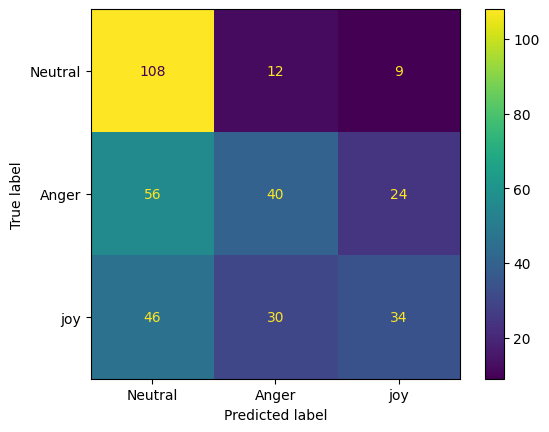

In [21]:
labels = ['Neutral', 'Anger', 'joy']

cf = confusion_matrix(true_label, predicted_label)
disp = ConfusionMatrixDisplay(cf, display_labels=labels)
disp.plot()
plt.show()

In [22]:
import keras.backend as K

print(K.eval(Ind_text_Context_LSTM_model_lr_fasttext.optimizer.lr))


0.01


Get predictions

In [23]:
df_test = pd.read_csv('test_sent_emo.csv', index_col=0)
df_test['image_names'] = df_test.apply(lambda row: f'dia{row["Dialogue_ID"]}_utt{row["Utterance_ID"]}', axis=1)
df_test

,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,image_names
Sr No.,,,,,,,,,,,
1,Why do all you’re coffee mugs have numbers on ...,Mark,surprise,none,0,0,3,19,"00:14:38,127","00:14:40,378",dia0_utt0
2,Oh. That’s so Monica can keep track. That way ...,Rachel,none,none,0,1,3,19,"00:14:40,629","00:14:47,385",dia0_utt1
3,Y'know what?,Rachel,none,none,0,2,3,19,"00:14:56,353","00:14:57,520",dia0_utt2
19,"Come on, Lydia, you can do it.",Joey,none,none,1,0,1,23,"0:10:44,769","0:10:46,146",dia1_utt0
20,Push!,Joey,none,none,1,1,1,23,"0:10:46,146","0:10:46,833",dia1_utt1
...,...,...,...,...,...,...,...,...,...,...,...
2760,"Yeah, I mean, come on Ross, no one will even n...",Rachel,none,none,279,11,6,4,"00:14:35,457","00:14:40,211",dia279_utt11
2761,They’re not listening too me?,Ross,surprise,none,279,12,6,4,"00:14:42,256","00:14:43,840",dia279_utt12
2762,Of course they’re listening to you! Everybody ...,Rachel,none,none,279,13,6,4,"00:14:44,008","00:14:48,511",dia279_utt13


In [24]:
df_test['Utterance_cleaned'] = clean(df_test['Utterance'] , lemmatize=True, stem=False, stopwords=True)

100%|██████████| 2610/2610 [00:00<00:00, 49216.97it/s]


In [25]:
test_vectors = [[model_ft.wv[word] for word in text] 
                 for text in df_test['Utterance']]  

test_vectors = tf.keras.utils.pad_sequences(test_vectors, maxlen = pad_len, dtype='float32', padding='post', truncating='post', value=0)

In [26]:
pred_final = (Ind_text_Context_LSTM_model_lr_fasttext.predict(test_vectors))

82/82 [==============================] - 3s 40ms/step


In [27]:
predicted_label_final = []

for i in range(pred_final.shape[0]):
	predicted_label_final.append(np.argmax(pred_final[i]))

final_predictions = pd.DataFrame(predicted_label_final, columns = ['Prediction'])

In [28]:
df_test['image_names'] = df_test['image_names'] + ','

final_predictions = pd.concat([df_test['image_names'].reset_index(drop=True), final_predictions], axis=1)

final_predictions = final_predictions.replace({0:'neutral',1:'anger',2:'joy'})


In [29]:
final_predictions.values

array([['dia0_utt0,', 'neutral'],
       ['dia0_utt1,', 'neutral'],
       ['dia0_utt2,', 'neutral'],
       ...,
       ['dia279_utt13,', 'joy'],
       ['dia279_utt14,', 'neutral'],
       ['dia279_utt15,', 'joy']], dtype=object)

In [30]:
np.savetxt(r'C:\\Users\\USER\\Desktop\\BPI\\Week 7\\projeto\\NLP_lstm.txt', final_predictions.values, fmt='%s')